In [9]:
# importing required classes 
from pypdf import PdfReader
import os


In [10]:
pdf_name = 'pdf1.pdf'
reader = PdfReader(f'docs/{pdf_name}')

In [12]:
text_files_dir = f"text/{pdf_name}"
if not os.path.isdir(text_files_dir):
    os.makedirs(text_files_dir)

In [16]:
for i in range(len(reader.pages)):
    print(f'Processing page nbr {i}')
    text = reader.pages[i].extract_text()
    text_file_name = f"{text_files_dir}/page_{i}.txt"
    with open(text_file_name, "x") as text_file:
        text_file.write(text)

Processing page nbr 0
Processing page nbr 1
Processing page nbr 2
Processing page nbr 3
Processing page nbr 4
Processing page nbr 5
Processing page nbr 6
Processing page nbr 7
Processing page nbr 8
Processing page nbr 9
Processing page nbr 10
Processing page nbr 11
Processing page nbr 12
Processing page nbr 13
Processing page nbr 14
Processing page nbr 15
Processing page nbr 16
Processing page nbr 17
Processing page nbr 18
Processing page nbr 19
Processing page nbr 20
Processing page nbr 21
Processing page nbr 22
Processing page nbr 23
Processing page nbr 24
Processing page nbr 25
Processing page nbr 26
Processing page nbr 27
Processing page nbr 28
Processing page nbr 29
Processing page nbr 30
Processing page nbr 31
Processing page nbr 32
Processing page nbr 33
Processing page nbr 34
Processing page nbr 35
Processing page nbr 36
Processing page nbr 37
Processing page nbr 38
Processing page nbr 39
Processing page nbr 40
Processing page nbr 41
Processing page nbr 42
Processing page nbr 4

In [14]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [15]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir(f"{text_files_dir}/"):

    # Open the file and read the text
    with open(f"{text_files_dir}/{file}", "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file, text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,page_24.txt,page_24.txt. Póliza de Seguro de Automotores L...
1,page_30.txt,page_30.txt. Póliza de Seguro de Automotores L...
2,page_18.txt,page_18.txt. Póliza de Seguro de Automotores L...
3,page_19.txt,page_19.txt. Póliza de Seguro de Automotores L...
4,page_31.txt,page_31.txt. Póliza de Seguro de Automotores L...


<Axes: >

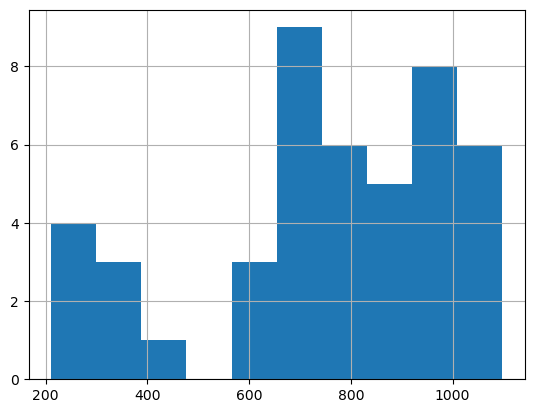

In [16]:
import tiktoken
import pandas as pd

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [17]:
from openai import OpenAI
client = OpenAI()

df['embeddings'] = df.text.apply(lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002').data[0].embedding)
df.to_csv('processed/embeddings.csv')
df.head()

,title,text,n_tokens,embeddings
0,page_24.txt,page_24.txt. Póliza de Seguro de Automotores L...,919,"[-0.018300291150808334, -0.0001406756200594827..."
1,page_30.txt,page_30.txt. Póliza de Seguro de Automotores L...,681,"[0.002368899527937174, 0.0074475351721048355, ..."
2,page_18.txt,page_18.txt. Póliza de Seguro de Automotores L...,610,"[-0.01696052774786949, 0.014104444533586502, 0..."
3,page_19.txt,page_19.txt. Póliza de Seguro de Automotores L...,809,"[-0.00761449197307229, 0.007823941297829151, 0..."
4,page_31.txt,page_31.txt. Póliza de Seguro de Automotores L...,727,"[-0.010724230669438839, 0.008463261649012566, ..."


In [18]:
from embeddings_utils import distances_from_embeddings

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = client.embeddings.create(input=question, model='text-embedding-ada-002').data[0].embedding

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=3000,
    size="ada",
    debug=False,
    max_tokens=800,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context

        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": f"Eres un asistente que tiene que responder info basado en este contexto: {context}"},
                {"role": "user", "content": f"{question}"}
            ],
            max_tokens=max_tokens,
            temperature=0,
            top_p=1,
            presence_penalty=0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(e)
        return ""

In [19]:
answer_question(df, model="gpt-4-turbo-preview", max_len=5000, question="cuanto de cobertura se tiene frente a un accidente de transito?", debug=False)

'La cobertura frente a un accidente de tránsito varía según el tipo de daño o pérdida involucrada y está sujeta a las condiciones particulares de la póliza LBC-Auto MASIVOS. A continuación, se detallan algunos aspectos clave de la cobertura según la información proporcionada:\n\n1. **Daños Propios o Robo Parcial**: En caso de siniestros menores a USD 1.000 que afecten exclusivamente Daños Propios o Robo Parcial, el asegurado puede optar por no reportar el siniestro, pero la aseguradora solo cubrirá hasta USD 1.000 si el asegurado decide reportarlo.\n\n2. **Muerte e Invalidez Total y/o Parcial Permanente**: La póliza cubre la muerte y la invalidez total y/o parcial permanente de los ocupantes del vehículo asegurado en caso de accidente de tránsito, según las escalas y condiciones especificadas en la póliza. Además, incluye gastos de sepelio para los ocupantes fallecidos.\n\n3. **Daños Materiales**: La póliza indemnizará los daños materiales que sufra el vehículo como consecuencia de un 